In [1]:
!pip install wordcloud
!pip install "jupyterlab>=3" "ipywidgets>=7.6"
!pip install plotly==5.10.0
!pip install altair

!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install gensim
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import sklearn
import altair as alt
import plotly.express as px
import sklearn
import pickle
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nltk.download('stopwords')
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import RepeatCorpus
import gensim
from gensim.utils import simple_preprocess



stop_words = set(nltk.corpus.stopwords.words('english'))
alt.data_transformers.disable_max_rows()

#df=pd.read_csv('complaints_01012015_12312015.csv')
df=pd.read_csv('complaints.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/DanielYoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/kk/5v4vwy_j2d956bxz3ntns0kh0000gn/T/ipykernel_96161/2441303143.py:25: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('complaints.csv')


In [3]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-10-26,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,AL,36401.0,NaN,NaN,Web,2022-10-26,In progress,Yes,NaN,6131974
1,2022-10-26,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92405.0,Servicemember,NaN,Web,2022-10-26,Closed with explanation,Yes,NaN,6132151
2,2022-10-26,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,PA,19083.0,NaN,NaN,Web,2022-10-26,In progress,Yes,NaN,6129551
3,2022-10-26,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,TX,77407.0,NaN,NaN,Web,2022-10-26,In progress,Yes,NaN,6132355
4,2022-10-26,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,NC,28304.0,NaN,NaN,Web,2022-10-26,In progress,Yes,NaN,6132273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047708,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,84054.0,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
3047709,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,74066.0,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
3047710,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,55379.0,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
3047711,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30215.0,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586


In [4]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235294
Issue                                 0
Sub-issue                        680835
Consumer complaint narrative    1954369
Company public response         1725992
Company                               0
State                             39972
ZIP code                          40380
Tags                            2700704
Consumer consent provided?       813368
Submitted via                         0
Date sent to company                  0
Company response to consumer          4
Timely response?                      0
Consumer disputed?              2279270
Complaint ID                          0
dtype: int64

In [5]:
df['Date_received_dt'] = pd.to_datetime(df['Date received'], format='%Y/%m/%d')



In [6]:
df['Consumer complaint narrative']

0                                                        NaN
1                                                        NaN
2                                                        NaN
3                                                        NaN
4                                                        NaN
                                 ...                        
3047708    I have disputed my debts several times with no...
3047709    My father died in XX/XX/XXXX. Left me his only...
3047710    cfbp i would Like to file a complaint on Exper...
3047711    My husband and I are in the middle of an FHA S...
3047712                                                  NaN
Name: Consumer complaint narrative, Length: 3047713, dtype: object

In [7]:
top5=df.groupby('Company')['Complaint ID'].count().reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            .head(5)

top5

,Company,count
2062,"EQUIFAX, INC.",518348
5838,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",423429
2224,Experian Information Solutions Inc.,396743
748,"BANK OF AMERICA, NATIONAL ASSOCIATION",118973
6333,WELLS FARGO & COMPANY,100824


In [18]:
top_5_list = list(top5['Company'])


df = df.dropna(subset=['Consumer complaint narrative'])

df_equifax = df[df['Company'] == 'EQUIFAX, INC.']
df_transition_intermediate = df[df['Company'] == 'TRANSUNION INTERMEDIATE HOLDINGS, INC.']
df_experian = df[df['Company'] == 'Experian Information Solutions Inc.']
df_boa = df[df['Company'] == 'BANK OF AMERICA, NATIONAL ASSOCIATION']
df_wells_fargo = df[df['Company'] == 'WELLS FARGO & COMPANY']

len(df_boa)

29334

In [20]:
import re 
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing text = text.lower()'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[x*\/]', '', text) #remove those dates with the format of XX/XX OR XXXX/XX/XX
    text = re.sub('x', '', text)#remove \n
    text = re.sub('\n', '', text)#remove \n
    return text

round1 = lambda x: clean_text(x)

In [29]:
data_clean_equifax = pd.DataFrame(df_equifax['Consumer complaint narrative'].apply(round1))
data_clean_transition_intermediate = pd.DataFrame(df_transition_intermediate['Consumer complaint narrative'].apply(round1)) 
data_clean_experian = pd.DataFrame(df_experian['Consumer complaint narrative'].apply(round1)) 
data_clean_boa = pd.DataFrame(df_boa['Consumer complaint narrative'].apply(round1)) 
data_clean_wells_fargo = pd.DataFrame(df_wells_fargo['Consumer complaint narrative'].apply(round1)) 


In [24]:
stop_words = stopwords.words('english') 
stop_words.extend(['sent','told','received','said','asked','made','contacted','know','spoke',
                   'company','will', 'XXXX', 'xxxx', 'XXXXXXXX', 'could', 'would', 'get'])

# Words Cloud_Equifax (Top 1)

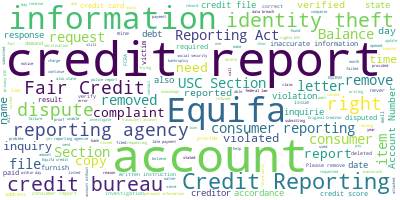

In [25]:
long_string = ','.join(list(data_clean_equifax['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', stopwords=stop_words) # Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Words Cloud_transition_intermediate (Top 2)

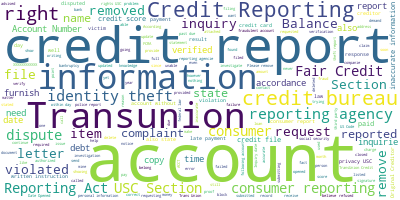

In [30]:
long_string = ','.join(list(data_clean_transition_intermediate['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', stopwords=stop_words) # Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Words Cloud_experian (Top 3)

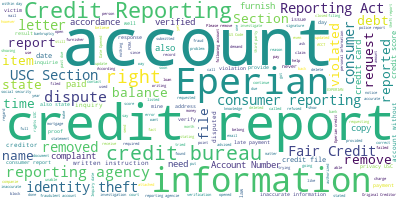

In [32]:
long_string = ','.join(list(data_clean_experian['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', stopwords=stop_words) # Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Words Cloud_experian (Top 4)

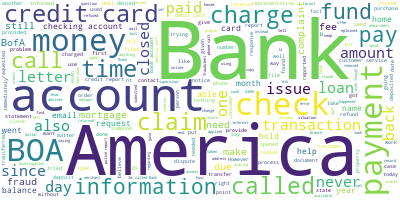

In [33]:
long_string = ','.join(list(data_clean_boa['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', stopwords=stop_words) # Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Words Cloud_experian (Top 5)

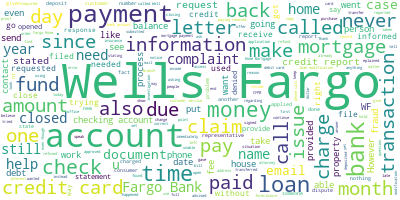

In [35]:
long_string = ','.join(list(data_clean_wells_fargo['Consumer complaint narrative'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', stopwords=stop_words) # Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()